<a href="https://colab.research.google.com/github/KatePomazunova/GoIT_HW_DS/blob/main/hw10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
from skimage.transform import resize
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16

In [2]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.array([tf.image.resize(np.expand_dims(x, axis=-1), (32, 32)) for x in x_train])
x_test = np.array([tf.image.resize(np.expand_dims(x, axis=-1), (32, 32)) for x in x_test])

x_train = np.stack((x_train, x_train, x_train), axis=-1)
x_test = np.stack((x_test, x_test, x_test), axis=-1)

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

print(x_train.shape)

num_classes = 10
learning_rate = 0.001
batch_size = 512

steps_per_epoch = len(x_train) // batch_size

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Налаштування обробки тренувального набору даних
dataset_train = (dataset_train
                 .repeat()
                 .shuffle(1024)
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )

# Створення об'єкту Dataset для тестових даних
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 32, 32, 3)


In [3]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

model = Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax"),
    ])

# Print the model summary
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [4]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              metrics=["accuracy"])

In [5]:
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)
tf_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)
tf_model = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks = [lr_scheduler, tf_stopping, tf_model]

In [ ]:
history = model.fit(dataset_train,
                    epochs=10,
                    batch_size=512,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=dataset_test,
                    callbacks=callbacks)

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 2.2555 - accuracy: 0.7285
Epoch 1: val_accuracy improved from -inf to 0.77540, saving model to best_model.h5
117/117 [==============================] - 752s 6s/step - loss: 2.2555 - accuracy: 0.7285 - val_loss: 1.0095 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/117 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.8110
Epoch 2: val_accuracy improved from 0.77540 to 0.79910, saving model to best_model.h5
117/117 [==============================] - 735s 6s/step - loss: 0.7378 - accuracy: 0.8110 - val_loss: 0.6930 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8440
Epoch 3: val_accuracy improved from 0.79910 to 0.82470, saving model to best_model.h5
117/117 [==============================] - 732s 6s/step - loss: 0.4735 - accuracy: 0.8440 - val_loss: 0.5716 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 4/10
117/117 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8716
Epoch 4: val_accuracy improved from 0.82470 to 0.83370, saving model to best_model.h5
117/117 [==============================] - 730s 6s/step - loss: 0.3636 - accuracy: 0.8716 - val_loss: 0.5294 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 5/10
117/117 [==========

In [11]:
pred_test = model(x_test)
predicted_labels = tf.argmax(pred_test, axis=1).numpy()

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='macro')
recall = recall_score(y_test, predicted_labels, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8515
Precision: 0.8518685096997547
Recall: 0.8515


HW10/1 - Accuracy: 0.8887
Precision: 0.8901669627810224
Recall: 0.8886999999999998

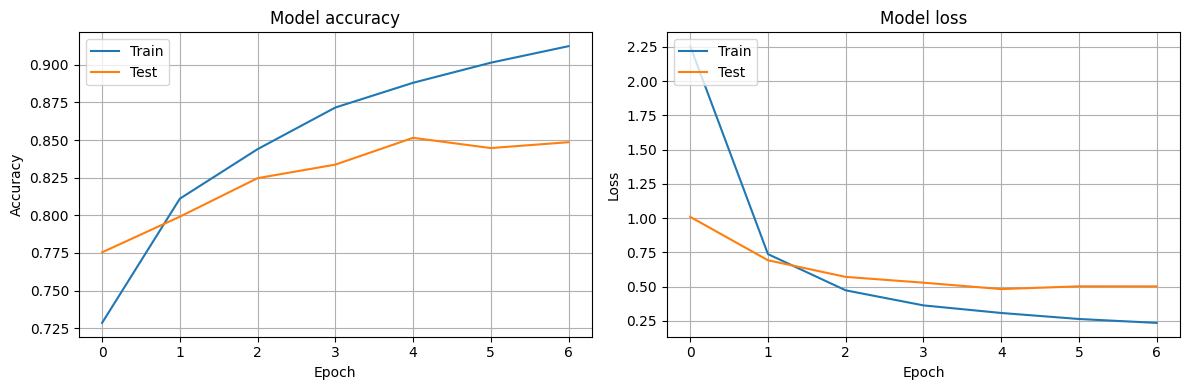

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

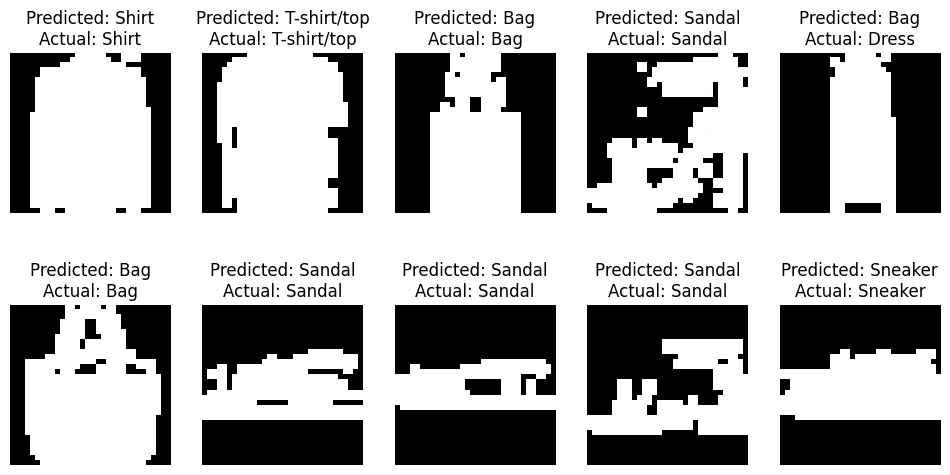

False 1 / 10.
Accuracy: 90.00%


In [18]:
rand_id = random.sample(range(len(x_test)), 10)
test_images = x_test[rand_id]
test_labels = y_test[rand_id]

predictions = model(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_images[i] * 255, [32, 32, 3]), cmap='gray')
    plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[test_labels[i]]}')
    plt.axis('off')

plt.show()

false_pred= np.sum(predicted_labels != test_labels)
accuracy = 1.0 - (false_pred / 10.0)

print(f"False {false_pred} / 10.")
print(f"Accuracy: {accuracy * 100:.2f}%")